In [46]:
# Импорт библиотек
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split
from keras.preprocessing import image

In [47]:
# Загрузим google диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Сохраним путь к папкам со снимками
path_head = '/content/drive/MyDrive/datasets/body_parts/head'
path_chest = '/content/drive/MyDrive/datasets/body_parts/chest'
path_hand = '/content/drive/MyDrive/datasets/body_parts/hand'
path_shoulder = '/content/drive/MyDrive/datasets/body_parts/shoulder'
path_knee = '/content/drive/MyDrive/datasets/body_parts/knee'
path_test = '/content/drive/MyDrive/datasets/body_parts/test'

In [49]:
# Сформируем список из названий файлов
files_head = os.listdir(path_head)
files_chest = os.listdir(path_chest)
files_hand = os.listdir(path_hand)
files_shoulder = os.listdir(path_shoulder)
files_knee = os.listdir(path_knee)

In [50]:
# Создадим списки с labels
labels_head = []
labels_chest = []
labels_hand = []
labels_shoulder = []
labels_knee = []
for i in range(len(files_head)):
    labels_head.append('head')
for i in range(len(files_chest)):
    labels_chest.append('chest')
for i in range(len(files_hand)):
    labels_hand.append('hand')
for i in range(len(files_shoulder)):
    labels_shoulder.append('shoulder')
for i in range(len(files_knee)):
    labels_knee.append('knee')

In [51]:
# Сформируем словари для последующего создания датафреймов
data_head = {'file_name': (i for i in files_head), 'body_part': (j for j in labels_head)}
data_chest = {'file_name': (i for i in files_chest), 'body_part': (j for j in labels_chest)}
data_hand = {'file_name': (i for i in files_hand), 'body_part': (j for j in labels_hand)}
data_shoulder = {'file_name': (i for i in files_shoulder), 'body_part': (j for j in labels_shoulder)}
data_knee = {'file_name': (i for i in files_knee), 'body_part': (j for j in labels_knee)}

In [52]:
# Создадим датафреймы
df_brain = pd.DataFrame(data_head)
df_chest = pd.DataFrame(data_chest)
df_hand = pd.DataFrame(data_hand)
df_shoulder = pd.DataFrame(data_shoulder)
df_knee = pd.DataFrame(data_knee)

In [53]:
# Объединим два датафрейма в один и перемешаем его
df = pd.concat([df_brain, df_chest, df_hand, df_shoulder, df_knee], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

5709

In [55]:
# Создадим ImageDataGenerator для форматирования изображений
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

In [56]:
# Преобразуем изображения для обучающей выборки
train_generator = datagen.flow_from_dataframe(dataframe=df, directory='/content/drive/MyDrive/datasets/body_parts/x-rays',
                                             x_col='file_name',
                                             y_col='body_part',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=True,
                                             subset='training',
                                             seed=12345)


Found 4568 validated image filenames belonging to 5 classes.


In [57]:
# Преобразуем изображения для валидационной выборки
validation_generator = datagen.flow_from_dataframe(dataframe=df, directory='/content/drive/MyDrive/datasets/body_parts/x-rays',
                                             x_col='file_name',
                                             y_col='body_part',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=8,
                                             subset='validation',
                                             seed=12345)

Found 1141 validated image filenames belonging to 5 classes.


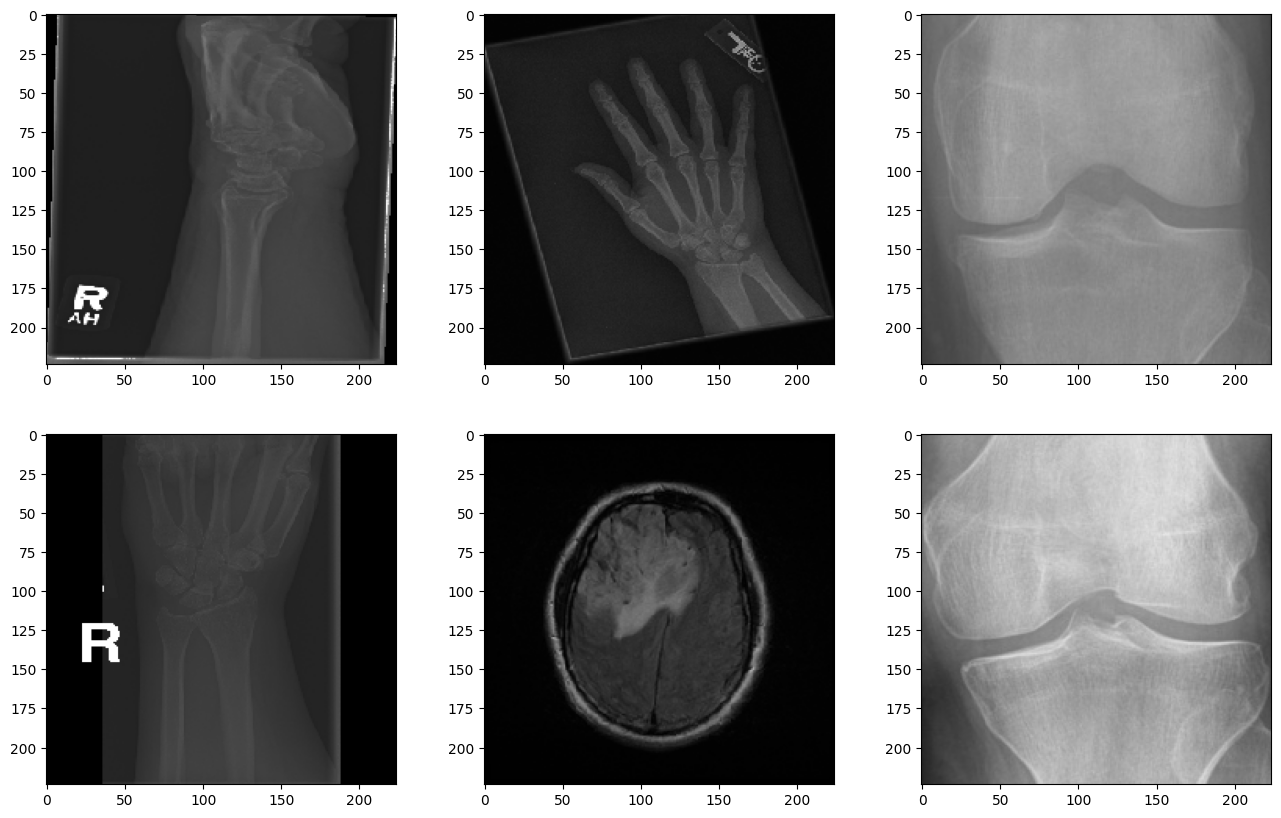

In [58]:
# Посмотрим на снимки
features, target = next(train_generator)
pic_box = plt.figure(figsize=(16, 10))
for i in range(6):
    pic_box.add_subplot(2, 3, i+1)
    plt.imshow(features[i])

In [59]:
# Создадим модель для обучения
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics=['accuracy'])

In [60]:
# Обучим модель
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,steps_per_epoch=train_steps, epochs=3,
                              validation_data=validation_generator,validation_steps=validation_steps)

Epoch 1/3
571/571 [==============================] - 656s 1s/step - loss: 0.2088 - accuracy: 0.9429 - val_loss: 0.0471 - val_accuracy: 0.9833
Epoch 2/3
571/571 [==============================] - 531s 930ms/step - loss: 0.0613 - accuracy: 0.9825 - val_loss: 0.0595 - val_accuracy: 0.9850
Epoch 3/3
571/571 [==============================] - 511s 895ms/step - loss: 0.0261 - accuracy: 0.9932 - val_loss: 0.0464 - val_accuracy: 0.9894


In [61]:
# Сохраним модель
model.save('/content/drive/MyDrive/datasets/chest_and_brain/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
# Загрузим сохраненную модель
model = keras.models.load_model('/content/drive/MyDrive/datasets/chest_and_brain/my_model.h5')

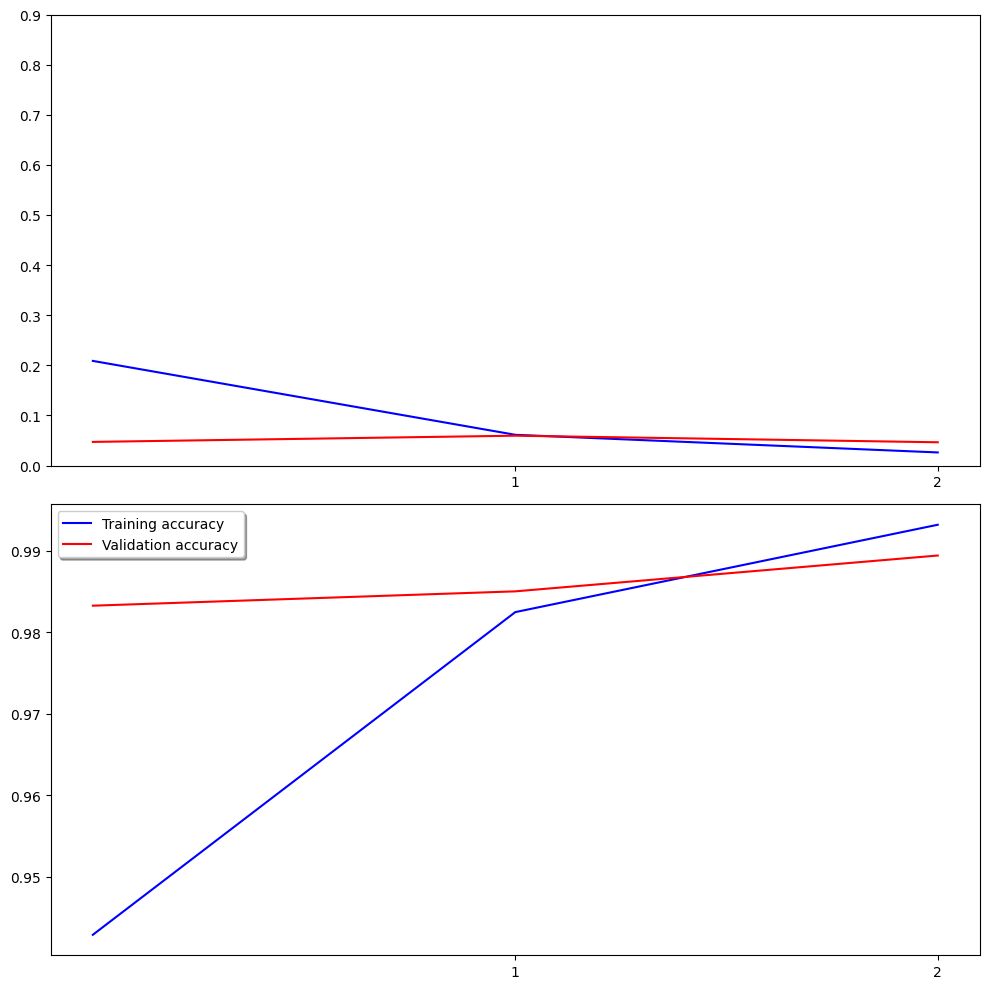

In [70]:
# Построим графики динамики обучения модели в зависимости от эпох
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 3, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 3, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [72]:
# Создадим функцию для классификации тестовых изображений
def test_classification(model, path=None):
    test = os.listdir(path)
    df_test = pd.DataFrame({'file_name': (i for i in test)})
    test_datagen = ImageDataGenerator(rescale=1/255.0)
    test_generator = test_datagen.flow_from_dataframe(directory=path, target_size=(224,224),
                                                 dataframe=df_test,
                                                 x_col='file_name',
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=12345)
    test_generator.reset()
    pred=model.predict(test_generator)
    predictions = []
    for i in pred:
        if np.argmax(i) == 0:
            predictions.append('chest')
        elif np.argmax(i) == 1:
            predictions.append('hand')
        elif np.argmax(i) == 2:
            predictions.append('head')
        elif np.argmax(i) == 3:
            predictions.append('knee')
        elif np.argmax(i) == 4:
            predictions.append('shoulder')
    filenames=test_generator.filenames
    results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
    return results

In [73]:
# Проверка модели на тесте
test_classification(model, path='/content/drive/MyDrive/datasets/body_parts/test/chest')

Found 37 validated image filenames.
37/37 [==============================] - 1s 29ms/step


,Filename,Predictions
0,000134 (9).png,chest
1,000132 (7).png,chest
2,000132 (2).png,chest
3,137covid_patient115_SR_2_IM00030.png,chest
4,137covid_patient115_SR_2_IM00027.png,chest
5,137covid_patient115_SR_2_IM00029.png,chest
6,137covid_patient115_SR_2_IM00028.png,chest
7,137covid_patient115_SR_2_IM00025.png,chest
8,137covid_patient115_SR_2_IM00024.png,chest
9,137covid_patient115_SR_2_IM00016.png,chest
